<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/Macrocircuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/projects/project-notebooks/Macrocircuits.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Macrocircuits

***Macrocircuits: Leveraging neural architectural priors and modularity in embodied agents***

**By Neuromatch Academy**

**Content creators:** Divyansha Lachi, Kseniia Shilova  

**Content reviewers:** Eva Dyer, Hannah Choi  

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

---

## Background
This project explores how we can build a biologically inspired artificial neural network (ANN) architecture, derived from the C. Elegans motor circuit, for the control of a simulated Swimmer agent. Traditional motor control ANNs often rely on generic, fully connected multilayer perceptrons (MLPs), which demand extensive training data, offer limited transferability, and possess complex internal dynamics that challenge interpretability. The project aims to understand how the biologically motivated ANN, which is shaped by evolution to be highly structured and sparse, could help to solve these problems and provide advantages in the domain of motor control. We will train MLPs using algorithms such as PPO, DDPG, and ES, and compare their performance in terms of rewards and sample efficiency with our bio-inspired ANN. The project also includes visualizing the C. Elegans connectome and building the network using this circuitry. We will conduct various ablation analyses by removing sign and weight-sharing constraints, and altering environmental parameters like the swimmer’s length or viscosity. These investigations aim to understand how architecture and modularity impact performance and learning across different environments. Finally, the project aims at building an agent that is robust to environmental variations, navigating towards specific targets, and enhancing our understanding of bio-inspired motor control.  


**Relevant references:**  

- [Neural circuit architectural priors for embodied control](https://arxiv.org/abs/2201.05242)  
- [Hierarchical motor control in mammals and machines](https://www.nature.com/articles/s41467-019-13239-6)  
- [Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)  

*This notebook uses code from the following GitHub repository:* [ncap](https://github.com/nikhilxb/ncap) by Nikhil X. Bhattasali and Anthony M. Zador and Tatiana A. Engel.

**Infrastructure note:** This notebook contains GPU install guide as well as CPU ones for different OS.

In [1]:
!rm -rf /kaggle/working/*

In [2]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()

feedback_prefix = "Project_Macrocircuits"

In [3]:
#@title Project Template
from IPython.display import Image, display
import os
from pathlib import Path

url = "https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/NCAPProjectTemplate.png?raw=true"

display(Image(url=url))

**Tutorial links**

This particular project connects a couple of distinct ideas explored throughout the course. Firstly, the innate ability to learn a certain set of actions quickly is the main topic of [Tutorial 4](https://neuroai.neuromatch.io/tutorials/W2D4_Macrolearning/student/W2D4_Tutorial4.html) for **W2D4** on biological meta-learning. The focus comes with the observation that the brain is not of a generic architecture but is a highly structured and optimized hierarchy of modules, the importance of which is highlighted in [Tutorial 3](https://neuroai.neuromatch.io/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial3.html) for **W2D1**, forming inductive bias for efficient motor control. The default model for the agent used here is already known Actor-Critic; you had the opportunity to observe in already mentioned tutorials as well as in [Tutorial 3](https://neuroai.neuromatch.io/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial3.html) for **W1D2**.

---
## Scetion 0: Initial setup

**IF USING KAGGLE (recommended):**

Uncomment the cell below and run it.

In [4]:
# @title Installing Dependencies (Kaggle GPU case, uncomment if you want to use this one)

import subprocess

subprocess.run(["sudo", "apt-get", "install", "-y", "libgl1-mesa-glx", "libosmesa6"])
subprocess.run(["pip", "install", "-q", "imageio[ffmpeg]"])

print('Installing dm_control...')
!pip install -q dm_control>=1.0.16

%env MUJOCO_GL=osmesa

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")
!pip install -q dm-acme[envs]
!mkdir output_videos

Reading package lists...
Building dependency tree...
Reading state information...
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
The following NEW packages will be installed:
  libosmesa6
0 upgraded, 1 newly installed, 0 to remove and 69 not upgraded.
Need to get 3054 kB of archives.
After this operation, 13.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libosmesa6 amd64 21.2.6-0ubuntu0.1~20.04.2 [3054 kB]


dpkg-preconfigure: unable to re-open stdin: No such file or directory


Fetched 3054 kB in 0s (24.0 MB/s)
Selecting previously unselected package libosmesa6:amd64.
(Reading database ... 110195 files and directories currently installed.)
Preparing to unpack .../libosmesa6_21.2.6-0ubuntu0.1~20.04.2_amd64.deb ...
Unpacking libosmesa6:amd64 (21.2.6-0ubuntu0.1~20.04.2) ...
Setting up libosmesa6:amd64 (21.2.6-0ubuntu0.1~20.04.2) ...
Processing triggers for libc-bin (2.31-0ubuntu9.14) ...
Installing dm_control...
env: MUJOCO_GL=osmesa
Installed dm_control 1.0.20


**Imports and Utility Functions**

In [5]:
#@title Importing Libraries
import numpy as np
import collections
import argparse
import os
import yaml
import typing as T
import imageio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns
from IPython.display import HTML

import dm_control as dm
import dm_control.suite.swimmer as swimmer
from dm_control.rl import control
from dm_control.utils import rewards
from dm_control import suite
from dm_control.suite.wrappers import pixels

from acme import wrappers

from torch import nn

In [6]:
#@title Utility code for displaying videos
def write_video(
  filepath: os.PathLike,
  frames: T.Iterable[np.ndarray],
  fps: int = 60,
  macro_block_size: T.Optional[int] = None,
  quality: int = 10,
  verbose: bool = False,
  **kwargs,
):
  """
  Saves a sequence of frames as a video file.

  Parameters:
  - filepath (os.PathLike): Path to save the video file.
  - frames (Iterable[np.ndarray]): An iterable of frames, where each frame is a numpy array.
  - fps (int, optional): Frames per second, defaults to 60.
  - macro_block_size (Optional[int], optional): Macro block size for video encoding, can affect compression efficiency.
  - quality (int, optional): Quality of the output video, higher values indicate better quality.
  - verbose (bool, optional): If True, prints the file path where the video is saved.
  - **kwargs: Additional keyword arguments passed to the imageio.get_writer function.

  Returns:
  None. The video is written to the specified filepath.
  """

  with imageio.get_writer(filepath,
                        fps=fps,
                        macro_block_size=macro_block_size,
                        quality=quality,
                        **kwargs) as video:
    if verbose: print('Saving video to:', filepath)
    for frame in frames:
      video.append_data(frame)


def display_video(
  frames: T.Iterable[np.ndarray],
  filename='output_videos/temp.mp4',
  fps=60,
  **kwargs,
):
  """
  Displays a video within a Jupyter Notebook from an iterable of frames.

  Parameters:
  - frames (Iterable[np.ndarray]): An iterable of frames, where each frame is a numpy array.
  - filename (str, optional): Temporary filename to save the video before display, defaults to 'output_videos/temp.mp4'.
  - fps (int, optional): Frames per second for the video display, defaults to 60.
  - **kwargs: Additional keyword arguments passed to the write_video function.

  Returns:
  HTML object: An HTML video element that can be displayed in a Jupyter Notebook.
  """

  # Write video to a temporary file.
  filepath = os.path.abspath(filename)
  write_video(filepath, frames, fps=fps, verbose=False, **kwargs)

  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/fps
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())


In this notebook we will explore the major components essential for this project.


*   **Understanding the DeepMind Control Suite Swimmer Agent:** We will begin by exploring the swimmer agent provided by the DeepMind Control Suite. This section includes a detailed exploration of the agent's API, task customization capabilities, and how to adapt the environment to fit our experimental needs.
*   **Training Models Using Various Reinforcement Learning Algorithms:** Next, we move on to learn how can we train models for the agents we created. We will be using Tonic_RL library to train our model. We will first train a standard MLP model using the Proximal Policy Optimization (PPO) algorithm.

* **Training the NCAP model:** Finally we will define the NCAP model from [Neural Circuit Architectural Priors for Embodied Control](https://arxiv.org/abs/2201.05242) paper. We will train it using PPO and compare it against the MLP model we trained before.

---
## Section 1: Exploring the DeepMind Swimmer

### 1.1 Create a basic swim task for the swimmer environment

First, we'll initialize a basic swimmer agent consisting of 6 links. Each agent requires a defined task and its corresponding reward function. In this instance, we've designed a swim forward task that involves the agent swimming forward in any direction.

The environment is flexible, allowing for modifications to introduce additional tasks such as "swim only in the x-direction" or "move towards a ball."

In [7]:
_SWIM_SPEED = 0.1

@swimmer.SUITE.add()
def swim(
  n_links=6,
  desired_speed=_SWIM_SPEED,
  time_limit=swimmer._DEFAULT_TIME_LIMIT,
  random=None,
  viscosity=0.001,
  density=3000,
  environment_kwargs={},
):
  """Returns the Swim task for a n-link swimmer."""
  model_string, assets = swimmer.get_model_and_assets(n_links)
  s2=str(model_string, encoding='utf-8').replace('density="3000"', 'density="{0}" viscosity="{1}"'.format(str(density), str(viscosity)))
  model_string=bytes(s2,encoding='utf-8')
  physics = swimmer.Physics.from_xml_string(model_string, assets=assets)
  task = Swim(desired_speed=desired_speed, random=random)
  return control.Environment(
    physics,
    task,
    time_limit=time_limit,
    control_timestep=swimmer._CONTROL_TIMESTEP,
    **environment_kwargs,
  )


class Swim(swimmer.Swimmer):
  """Task to swim forwards at the desired speed."""
  def __init__(self, desired_speed=_SWIM_SPEED, **kwargs):
    super().__init__(**kwargs)
    self._desired_speed = desired_speed

  def initialize_episode(self, physics):
    super().initialize_episode(physics)
    # Hide target by setting alpha to 0.
    physics.named.model.mat_rgba['target', 'a'] = 0
    physics.named.model.mat_rgba['target_default', 'a'] = 0
    physics.named.model.mat_rgba['target_highlight', 'a'] = 0

  def get_observation(self, physics):
    """Returns an observation of joint angles and body velocities."""
    obs = collections.OrderedDict()
    obs['joints'] = physics.joints()
    obs['body_velocities'] = physics.body_velocities()
    return obs

  def get_reward(self, physics):
    """Returns a smooth reward that is 0 when stopped or moving backwards, and rises linearly to 1
    when moving forwards at the desired speed."""
    forward_velocity = -physics.named.data.sensordata['head_vel'][1]
    return rewards.tolerance(
      forward_velocity,
#       bounds=(self._desired_speed * 0.9, self._desired_speed * 1.1),
#       margin=self._desired_speed * 0.5,
      bounds=(self._desired_speed, float('inf')),
      margin=self._desired_speed,
      value_at_margin=0.,
      sigmoid='linear',
    )

### 1.2 Vizualizing an agent that takes random actions in the environment

Let's visualize the environment by executing a sequence of random actions on a swimmer agent. This involves applying random actions over a series of steps and compiling the rendered frames into a video to visualize the agent's behavior.

In [8]:
""" Renders the current environment state to an image """
def render(env):
    return env.physics.render(camera_id=0, width=640, height=480)

""" Tests a DeepMind control suite environment by executing a series of random actions """
def test_dm_control(env):
    env = wrappers.CanonicalSpecWrapper(env, clip=True)
    env = wrappers.SinglePrecisionWrapper(env)

    spec = env.action_spec()
    timestep = env.reset()
    frames = [render(env)]

    for _ in range(60):
        action = np.random.uniform(low=spec.minimum, high=spec.maximum, size=spec.shape)
        timestep = env.step(action)
        frames.append(render(env))
    return display_video(frames)

In [9]:
env = suite.load('swimmer', 'swim', task_kwargs={'random': 1, 'viscosity':0.1, 'density':5000})

In [10]:
test_dm_control(env)

### 1.3 Swimmer Agent API

The observation space consists of 25 total dimensions, combining joint positions and body velocities, while the action space involves 5 dimensions representing normalized joint forces.


**Observation Space**: 4k - 1 total (k = 6 $\rightarrow$ 23)

- k - 1: joint positions $q_i \in [-\pi, \pi]$ (`joints`)
- 3k: link linear velocities $vx_i, vy_i \in \mathbb{R}$ and rotational velocity $wz_i \in \mathbb{R}$ (`body_velocities`)

In [11]:
env.observation_spec()

OrderedDict([('joints',
              Array(shape=(5,), dtype=dtype('float64'), name='joints')),
             ('body_velocities',
              Array(shape=(18,), dtype=dtype('float64'), name='body_velocities'))])

**Action Space**: k - 1 total (k = 6 $\rightarrow$ 5)

- k - 1: joint normalized force $\ddot{q}_i \in [-1, 1]$

In [12]:
env.action_spec()

BoundedArray(shape=(5,), dtype=dtype('float64'), name=None, minimum=[-1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1.])

In [13]:
def extract_weights(path):
    checkpoint = torch.load(path)
    pt_keys = list(checkpoint.keys())
    pt_dict = {}
    for key in pt_keys:
        pt_dict[key] = np.array(checkpoint[key])
    return pt_dict

### 1.4 Example of simple modification to the agent

Using the API provided by Deepmind we can create any kind of changes to the agent and the environment.

Try to make the following changes to make yourself more familiar with the swimmer.

*   ***Adding a target (like a ball) to this environment at some x distance away from the agent.***
*   ***Increasing the viscosity of the environment.***



Have a look at the following links to see what kind of assets you will need to modify to make these changes.


*   [swimmer.py](https://github.com/google-deepmind/dm_control/blob/main/dm_control/suite/swimmer.py)
*   [swimmer.xml](https://github.com/google-deepmind/dm_control/blob/main/dm_control/suite/swimmer.xml)

---
## Section 2: Training models on the swim task


To train the agents we defined in the previous section, we will utilize standard reinforcement learning (RL) algorithms. For the purposes of this tutorial, we will employ the [tonic_rl](https://github.com/fabiopardo/tonic) library, which provides a robust framework for training RL agents. Throughout most of this project, you will primarily be modifying the environment or the model architecture. Therefore, I suggest treating these algorithms as a "black box" for now. Simply put, you input an untrained model, and the algorithm processes and returns a well-trained model. This approach allows us to focus on the impact of different architectures and environmental settings without delving deeply into the algorithmic complexities at this stage.

In [14]:
#@title Download and install tonic library for training agents

import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    !git clone https://github.com/neuromatch/tonic
    %cd tonic

### Section 2.1 Defining the train function

First we defined a general training function to train any agent on any given environment with a variety of available algorithms. Given below are some of the parameter definitions of the function. You'll likely want to adjust these parameters to customize the training process for an agent in a specific environment using your chosen algorithm from the tonic library:

* **Header**: Python code required to run before training begins, primarily for importing essential libraries or modules.

* **Agent**: The agent that will undergo training; refer to section 3.2 and 4.2 for definitions of MLP and NCAP respectively.

* **Environment**: The training environment for the agent. Ensure it is registered with the DeepMind Control Suite as detailed in section 2.

* **Name**: The experiment's name, which will be utilized for log and model saving purposes.

* **Trainer**: The trainer instance selected for use. It allows the configuration of the training steps, model saving frequency, and other training-related parameters.

In [15]:
import tonic
import tonic.torch

def train(
    header,
    agent,
    environment_builder,
    name='test',
    trainer='tonic.Trainer()',
    before_training=None,
    after_training=None,
    parallel=1,
    sequential=1,
    seed=0,
    task_kwargs={}
):
    args = dict(locals())

    if header:
        exec(header)

    environment = tonic.environments.distribute(
        lambda: environment_builder(**task_kwargs), 
        worker_groups=parallel, 
        workers_per_group=sequential
    )
    test_environment = tonic.environments.distribute(
        lambda: environment_builder(**task_kwargs), 
        worker_groups=1, 
        workers_per_group=1
    )

    agent = eval(agent)
    agent.initialize(
        observation_space=test_environment.observation_space,
        action_space=test_environment.action_space, 
        seed=seed
    )

    if hasattr(test_environment, 'name'):
        environment_name = test_environment.name
    else:
        environment_name = test_environment.__class__.__name__
    if not name:
        if hasattr(agent, 'name'):
            name = agent.name
        else:
            name = agent.__class__.__name__
        if parallel != 1 or sequential != 1:
            name += f'-{parallel}x{sequential}'

    path = os.path.join('data', 'local', 'experiments', 'tonic', environment_name, name)
    tonic.logger.initialize(path, script_path=None, config=args)

    trainer = eval(trainer)
    trainer.initialize(
        agent=agent,
        environment=environment,
        test_environment=test_environment,
    )
    if before_training:
        exec(before_training)

    trainer.run()

    if after_training:
        exec(after_training)


In [16]:
def build_swimmer_env(density=3000, viscosity=0.001, **kwargs):
    return tonic.environments.ControlSuite(
        "swimmer-swim", 
        task_kwargs={'density': density, 'viscosity': viscosity}, 
        **kwargs
    )

### Section 2.2 Training MLP model on swim task

Now we are going to define a function for creating an actor-critic model suitable for Proximal Policy Optimization (PPO) using a Multi-Layer Perceptron (MLP) architecture.

In [17]:
from tonic.torch import models, normalizers
import torch

def ppo_mlp_model(
  actor_sizes=(64, 64),
  actor_activation=torch.nn.Tanh,
  critic_sizes=(64, 64),
  critic_activation=torch.nn.Tanh,
):

  """
  Constructs an ActorCritic model with specified architectures for the actor and critic networks.

  Parameters:
  - actor_sizes (tuple): Sizes of the layers in the actor MLP.
  - actor_activation (torch activation): Activation function used in the actor MLP.
  - critic_sizes (tuple): Sizes of the layers in the critic MLP.
  - critic_activation (torch activation): Activation function used in the critic MLP.

  Returns:
  - models.ActorCritic: An ActorCritic model comprising an actor and a critic with MLP torsos,
    equipped with a Gaussian policy head for the actor and a value head for the critic,
    along with observation normalization.
  """

  return models.ActorCritic(
    actor=models.Actor(
      encoder=models.ObservationEncoder(),
      torso=models.MLP(actor_sizes, actor_activation),
      head=models.DetachedScaleGaussianPolicyHead(),
    ),
    critic=models.Critic(
      encoder=models.ObservationEncoder(),
      torso=models.MLP(critic_sizes, critic_activation),
      head=models.ValueHead(),
    ),
    observation_normalizer=normalizers.MeanStd(),
  )

Next we call the train function which initiates the training process for the provided agent using the Tonic library. It specifies the components necessary for training, including the model, environment, and training parameters:

**Agent**: A Proximal Policy Optimization (PPO) agent with a custom Multi-Layer Perceptron (MLP) model architecture, configured with 256 units in each of two layers for both the actor and the critic.

**Environment**: The training environment is set to "swimmer-swim" from the Control Suite, a benchmark suite for continuous control tasks.

**Name**: The experiment is named 'mlp_256', which is useful for identifying logs and saved models associated with this training run.

**Trainer**: Specifies the training configuration, including the total number of steps (5e5) and the frequency of saving the model (1e5 steps).


*Note:* The model will checkpoint every 'save_steps' amount of training steps*

⏳ 

The model can take some time to train so feel free to skip the training for now. We have provided the pretrained model for you to play with. Move on to the next section to vizualize a agent with the pretrained model.

Uncomment the cell below if you want to perform the training.

In [18]:
# train('import tonic.torch',
#       'tonic.torch.agents.PPO(model=ppo_mlp_model(actor_sizes=(256, 256), critic_sizes=(256,256)))',
#       environment_builder=build_swimmer_env,
#       name = 'mlp_256',
#       trainer = 'tonic.Trainer(steps=int(5e4),save_steps=int(1e4))',
#       task_kwargs={'density': 3000, 'viscosity': 0.001})

❓

**Try playing with the parameters of the trainer and the MLP model and see how it affects the performance.**


*   ***How do the actor and the critic model size affect the performance.***
*   ***Consider increasing the number of steps in trainer to train the model for longer.***
*   ***Explore [Tonic library](https://github.com/fabiopardo/tonic) to see what algorithms we can use to train our agents. (D4PG is usually faster than PPO)***

### Section 2.3 Function to run any model on the environment and generate video

One of the most fun things about these environments is their visualization. We don't want to just look at the reward to know how good our model is we want to see how well the agent swims. This is particularly important to avoid "reward hacking," where an agent learns to exploit the reward system in ways that are unintended and potentially detrimental to the desired outcomes. Moreover visualizing the agent also help us understand where the model is going wrong.

Here we have defined a function that will generate the videos of the agent using the input model. The function requires path to the checkpoint folder and the environment you wanna run the trained model on.

In [19]:
def train_and_save_models(
    header,
    agent,
    environment_builder,
    trainer_class='tonic.Trainer',
    before_training=None,
    after_training=None,
    parallel=1,
    sequential=1,
    seed=0,
    densities=[1000, 2000, 3000],  # Example densities
    viscosities=[0.001],  # Example viscosities
    steps=int(5e4),  # Number of training steps
    save_steps=int(1e4),  # Interval for saving checkpoints
    name='model',
    base_path='data/local/experiments/tonic'
):
    for density in densities:
        for viscosity in viscosities:
            _name = f'{name}_density_{density}_viscosity_{viscosity}'
            task_kwargs = {'density': density, 'viscosity': viscosity}

            train(
                header=header,
                agent=agent,
                environment_builder=environment_builder,
                name=_name,
                trainer=f'tonic.Trainer(steps={steps},save_steps={save_steps})',
                before_training=before_training,
                after_training=after_training,
                parallel=parallel,
                sequential=sequential,
                seed=seed,
                task_kwargs=task_kwargs
            )

            # Generate video for the trained model
            video_name = f'video_density_{density}_viscosity_{viscosity}.mp4'
            play_model(
                path=os.path.join(base_path, 'swimmer-swim', _name),
                checkpoint='last',
                environment_builder=environment_builder,
                seed=seed,
                header=header,
                task_kwargs=task_kwargs,
                video_name=video_name
            )

def play_model(path, checkpoint='last', environment_builder=None, seed=None, header=None, task_kwargs={}, video_name='video.mp4'):
    if checkpoint == 'none':
        checkpoint_path = None
        tonic.logger.log('Not loading any weights')
    else:
        checkpoint_path = os.path.join(path, 'checkpoints')
        if not os.path.isdir(checkpoint_path):
            tonic.logger.error(f'{checkpoint_path} is not a directory')
            checkpoint_path = None

        checkpoint_ids = []
        for file in os.listdir(checkpoint_path):
            if file[:5] == 'step_':
                checkpoint_id = file.split('.')[0]
                checkpoint_ids.append(int(checkpoint_id[5:]))

        if checkpoint_ids:
            if checkpoint == 'last':
                checkpoint_id = max(checkpoint_ids)
                checkpoint_path = os.path.join(checkpoint_path, f'step_{checkpoint_id}')
            elif checkpoint == 'first':
                checkpoint_id = min(checkpoint_ids)
                checkpoint_path = os.path.join(checkpoint_path, f'step_{checkpoint_id}')
            else:
                checkpoint_id = int(checkpoint)
                if checkpoint_id in checkpoint_ids:
                    checkpoint_path = os.path.join(checkpoint_path, f'step_{checkpoint_id}')
                else:
                    tonic.logger.error(f'Checkpoint {checkpoint_id} not found in {checkpoint_path}')
                    checkpoint_path = None
        else:
            tonic.logger.error(f'No checkpoint found in {checkpoint_path}')
            checkpoint_path = None

    arguments_path = os.path.join(path, 'config.yaml')
    with open(arguments_path, 'r') as config_file:
        config = yaml.load(config_file, Loader=yaml.FullLoader)
    config = argparse.Namespace(**config)

    try:
        if config.header:
            exec(config.header)
        if header:
            exec(header)
    except:
        pass

    agent = eval(config.agent)

    environment = tonic.environments.distribute(
        lambda: environment_builder(**task_kwargs), 
        worker_groups=1, 
        workers_per_group=1
    )

    agent.initialize(
        observation_space=environment.observation_space,
        action_space=environment.action_space,
        seed=seed,
    )

    if checkpoint_path:
        agent.load(checkpoint_path)

    steps = 0
    test_observations = environment.start()
    #frames = [environment.render('rgb_array', camera_id=0, width=640, height=480)[0]]
    score, length = 0, 0

    while True:
        actions = agent.test_step(test_observations, steps)
        assert not np.isnan(actions.sum())

        test_observations, infos = environment.step(actions)
        #frames.append(environment.render('rgb_array', camera_id=0, width=640, height=480)[0])
        agent.test_update(**infos, steps=steps)

        score += infos['rewards'][0]
        length += 1

        if infos['resets'][0]:
            break

    #video_path = os.path.join(path, video_name)
    print('Reward for the run: ', score)
    #save_video(frames, video_path)
    #print(f'Video saved to: {video_path}')
    
    return score


def save_video(frames, video_path):
    import cv2
    height, width, layers = frames[0].shape
    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    for frame in frames:
        video.write(frame)
    video.release()

In [20]:
# Define the environment builder function
def build_swimmer_env(density, viscosity, **kwargs):
    return tonic.environments.ControlSuite("swimmer-swim", task_kwargs={'density': density, 'viscosity': viscosity}, **kwargs)

# Train models on different densities and viscosities and generate videos
train_and_save_models(
    header='import tonic.torch',
    agent='tonic.torch.agents.PPO(model=ppo_mlp_model(actor_sizes=(256, 256), critic_sizes=(256, 256)))',
    environment_builder=build_swimmer_env,
    densities=[3000],  # Specify the densities you want to train on
    viscosities=[0.001],  # Specify the viscosities you want to train on
    steps=int(5e5),  # Number of training steps
    save_steps=int(5e4),  # Interval for saving checkpoints
    name='mlp',
    base_path='data/local/experiments/tonic'
)


/opt/conda/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Config file saved to data/local/experiments/tonic/swimmer-swim/mlp_density_3000_viscosity_0.001/config.yaml
          Time left:  epoch 0:00:00  total 0:16:23          
actor                                                       
  clip fraction                                        0.154
  entropy                                               1.05
  iterations                                            42.2
  kl                                                 0.00742
  loss                                               -0.0189
  std                                                  0.692
  stop                                                0.0118
critic                                                      
  iterations                                              80
  loss                                                  2.41
  v                                                     4.91
test                                                        
  action                              

/opt/conda/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")



Loading weights from data/local/experiments/tonic/swimmer-swim/mlp_density_3000_viscosity_0.001/checkpoints/step_500000.pt
Reward for the run:  977.1988882347941


In [21]:
def test_models_in_different_envs(
    base_path,
    densities,
    viscosities,
    test_envs,
    header='import tonic.torch',
    agent='tonic.torch.agents.PPO(model=ppo_swimmer_model(n_joints=5,critic_sizes=(256,256)))',
    environment_builder=None,
    seed=0,
    name='model'
):
    results = {}
    for density in densities:
        for viscosity in viscosities:
            model_name = f'{name}_density_{density}_viscosity_{viscosity}'
            model_path = os.path.join(base_path,'swimmer-swim', model_name)
            for test_env in test_envs:
                test_env_name = f'test_env_{test_env["name"]}'
                task_kwargs = {
                    'density': test_env.get('density', density),
                    'viscosity': test_env.get('viscosity', viscosity)
                }
                score = play_model(
                    path=model_path,
                    checkpoint='last',
                    environment_builder=environment_builder,
                    seed=seed,
                    header=header,
                    task_kwargs=task_kwargs,
                    video_name=f'video_{test_env_name}.mp4'
                )
                results[f'{model_name}_{test_env_name}'] = score
    return results

# Define the test environments as dictionaries
test_envs = [
    {'name': 'env_density_1000', 'density': 1000, 'viscosity': 0.001},
    {'name': 'env_density_3000', 'density': 3000, 'viscosity': 0.001},
    {'name': 'env_density_6000', 'density': 6000, 'viscosity': 0.001}
]


In [22]:
results = test_models_in_different_envs(
    base_path='data/local/experiments/tonic',
    densities=[3000],
    viscosities=[0.001],
    test_envs=test_envs,
    header='import tonic.torch',
    agent='tonic.torch.agents.PPO(model=ppo_swimmer_model(n_joints=5,critic_sizes=(256,256)))',
    environment_builder=build_swimmer_env,
    seed=0,
    name='mlp'
)
print(results)


Loading weights from data/local/experiments/tonic/swimmer-swim/mlp_density_3000_viscosity_0.001/checkpoints/step_500000.pt
Reward for the run:  976.2859818004072

Loading weights from data/local/experiments/tonic/swimmer-swim/mlp_density_3000_viscosity_0.001/checkpoints/step_500000.pt
Reward for the run:  969.9724352955818

Loading weights from data/local/experiments/tonic/swimmer-swim/mlp_density_3000_viscosity_0.001/checkpoints/step_500000.pt
Reward for the run:  693.2839577943087
{'mlp_density_3000_viscosity_0.001_test_env_env_density_1000': 976.2859818004072, 'mlp_density_3000_viscosity_0.001_test_env_env_density_3000': 969.9724352955818, 'mlp_density_3000_viscosity_0.001_test_env_env_density_6000': 693.2839577943087}


In [23]:

# Test the model with custom density and save the video with a specific name
# play_model(
#     path='data/local/experiments/tonic/swimmer-swim/mlp_256',
#     checkpoint='last',
#     environment_builder=build_swimmer_env,
#     task_kwargs={'density': 4000, 'seed': 42},
#     header='import tonic.torch',
#     video_name='custom_video.mp4'
# )

Let's visualize the agent with a pretrained MLP model. Once you have your pretrained model, you can replace the experiment path to visualize the agent with your model.

In [24]:
# play_model('data/local/experiments/tonic/swimmer-swim/mlp_256')
# play_model('data/local/experiments/tonic/swimmer-swim/pretrained_mlp_ppo')


Try testing the model on a modification of the enviroment it was trained on.


*   ***Train on basic swim task and test on a environment with higher viscosity.***
*   ***Can we train on the basic 6 link swimmer and test on a larger 12 link swimmer?***
* ***Train the model for a bit on the modified environment and see how quickly the model can adapt to the new environment.***

---
## Section 3: NCAP

Now that we are familiar with how to train standard models on the swimmer agent let's take a look at NCAP a model that was inspired from the C. elegans motor circuit.
Our hope with using such models is that they would already have really good priors which should lead to much better transfer, faster learning curves and possibly really good innate performance (zero shot performance).

Check out [NCAP paper](https://arxiv.org/abs/2201.05242) to learn more about the model.

In [25]:
#@title Paper Illustration

from IPython.display import Image, display
import os
from pathlib import Path

url = "https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/NCAPPaper.png?raw=true"

display(Image(url=url))

### 3.1 NCAP classes

Now we are going to define ***SwimmerModule*** (NCAP model) and ***SwimmerActor*** (wrapper around NCAP model to make it compatible with tonic) classes.

#### Section 3.1.1 Defining the constraints

In [26]:
# ==================================================================================================
# Weight constraints.


def excitatory(w, upper=None):
    return w.clamp(min=0, max=upper)


def inhibitory(w, lower=None):
    return w.clamp(min=lower, max=0)


def unsigned(w, lower=None, upper=None):
    return w if lower is None and upper is None else w.clamp(min=lower, max=upper)


# ==================================================================================================
# Activation constraints.


def graded(x):
    return x.clamp(min=0, max=1)


# ==================================================================================================
# Weight initialization.


def excitatory_uniform(shape=(1,), lower=0., upper=1.):
    assert lower >= 0
    return nn.init.uniform_(nn.Parameter(torch.empty(shape)), a=lower, b=upper)


def inhibitory_uniform(shape=(1,), lower=-1., upper=0.):
    assert upper <= 0
    return nn.init.uniform_(nn.Parameter(torch.empty(shape)), a=lower, b=upper)


def unsigned_uniform(shape=(1,), lower=-1., upper=1.):
    return nn.init.uniform_(nn.Parameter(torch.empty(shape)), a=lower, b=upper)


def excitatory_constant(shape=(1,), value=1.):
    return nn.Parameter(torch.full(shape, value))


def inhibitory_constant(shape=(1,), value=-1.):
    return nn.Parameter(torch.full(shape, value))


def unsigned_constant(shape=(1,), lower=-1., upper=1., p=0.5):
    with torch.no_grad():
        weight = torch.empty(shape).uniform_(0, 1)
        mask = weight < p
        weight[mask] = upper
        weight[~mask] = lower
        return nn.Parameter(weight)

***Can you think of more kinds of weight initializations and constraints that might be useful for the swimmer agent?***

#### Section 3.1.2: Defining the ***SwimmerModule***

The ***SwimmerModule*** class represents the neural network module inspired by the C. elegans neural circuitry, designed for controlling a robotic swimmer with specific architectural priors, such as proprioception and oscillatory movement patterns.

In [27]:
class SwimmerModule(nn.Module):
    """C.-elegans-inspired neural circuit architectural prior."""

    def __init__(
            self,
            n_joints: int,
            n_turn_joints: int = 1,
            oscillator_period: int = 60,
            use_weight_sharing: bool = True,
            use_weight_constraints: bool = True,
            use_weight_constant_init: bool = True,
            include_proprioception: bool = True,
            include_head_oscillators: bool = True,
            include_speed_control: bool = False,
            include_turn_control: bool = False,
    ):
        super().__init__()
        self.n_joints = n_joints
        self.n_turn_joints = n_turn_joints
        self.oscillator_period = oscillator_period
        self.include_proprioception = include_proprioception
        self.include_head_oscillators = include_head_oscillators
        self.include_speed_control = include_speed_control
        self.include_turn_control = include_turn_control

        # Log activity
        self.connections_log = []

        # Timestep counter (for oscillations).
        self.timestep = 0

        # Weight sharing switch function.
        self.ws = lambda nonshared, shared: shared if use_weight_sharing else nonshared

        # Weight constraint and init functions.
        if use_weight_constraints:
            self.exc = excitatory
            self.inh = inhibitory
            if use_weight_constant_init:
                exc_param = excitatory_constant
                inh_param = inhibitory_constant
            else:
                exc_param = excitatory_uniform
                inh_param = inhibitory_uniform
        else:
            self.exc = unsigned
            self.inh = unsigned
            if use_weight_constant_init:
                exc_param = inh_param = unsigned_constant
            else:
                exc_param = inh_param = unsigned_uniform

        # Learnable parameters.
        self.params = nn.ParameterDict()
        if use_weight_sharing:
            if self.include_proprioception:
                self.params['bneuron_prop'] = exc_param()
            if self.include_speed_control:
                self.params['bneuron_speed'] = inh_param()
            if self.include_turn_control:
                self.params['bneuron_turn'] = exc_param()
            if self.include_head_oscillators:
                self.params['bneuron_osc'] = exc_param()
            self.params['muscle_ipsi'] = exc_param()
            self.params['muscle_contra'] = inh_param()
        else:
            for i in range(self.n_joints):
                if self.include_proprioception and i > 0:
                    self.params[f'bneuron_d_prop_{i}'] = exc_param()
                    self.params[f'bneuron_v_prop_{i}'] = exc_param()

                if self.include_speed_control:
                    self.params[f'bneuron_d_speed_{i}'] = inh_param()
                    self.params[f'bneuron_v_speed_{i}'] = inh_param()

                if self.include_turn_control and i < self.n_turn_joints:
                    self.params[f'bneuron_d_turn_{i}'] = exc_param()
                    self.params[f'bneuron_v_turn_{i}'] = exc_param()

                if self.include_head_oscillators and i == 0:
                    self.params[f'bneuron_d_osc_{i}'] = exc_param()
                    self.params[f'bneuron_v_osc_{i}'] = exc_param()

                self.params[f'muscle_d_d_{i}'] = exc_param()
                self.params[f'muscle_d_v_{i}'] = inh_param()
                self.params[f'muscle_v_v_{i}'] = exc_param()
                self.params[f'muscle_v_d_{i}'] = inh_param()

    def reset(self):
        self.timestep = 0

    def log_activity(self, activity_type, neuron):
        """Logs an active connection between neurons."""
        self.connections_log.append((self.timestep, activity_type, neuron))

    def forward(
            self,
            joint_pos,
            right_control=None,
            left_control=None,
            speed_control=None,
            timesteps=None,
            log_activity=True,
            log_file='log.txt'
    ):
        """Forward pass.

    Args:
      joint_pos (torch.Tensor): Joint positions in [-1, 1], shape (..., n_joints).
      right_control (torch.Tensor): Right turn control in [0, 1], shape (..., 1).
      left_control (torch.Tensor): Left turn control in [0, 1], shape (..., 1).
      speed_control (torch.Tensor): Speed control in [0, 1], 0 stopped, 1 fastest, shape (..., 1).
      timesteps (torch.Tensor): Timesteps in [0, max_env_steps], shape (..., 1).

    Returns:
      (torch.Tensor): Joint torques in [-1, 1], shape (..., n_joints).
    """

        exc = self.exc
        inh = self.inh
        ws = self.ws

        # Separate into dorsal and ventral sensor values in [0, 1], shape (..., n_joints).
        joint_pos_d = joint_pos.clamp(min=0, max=1)
        joint_pos_v = joint_pos.clamp(min=-1, max=0).neg()

        # Convert speed signal from acceleration into brake.
        if self.include_speed_control:
            assert speed_control is not None
            speed_control = 1 - speed_control.clamp(min=0, max=1)

        joint_torques = []  # [shape (..., 1)]
        for i in range(self.n_joints):
            bneuron_d = bneuron_v = torch.zeros_like(joint_pos[..., 0, None])  # shape (..., 1)

            # B-neurons recieve proprioceptive input from previous joint to propagate waves down the body.
            if self.include_proprioception and i > 0:
                bneuron_d = bneuron_d + joint_pos_d[
                    ..., i - 1, None] * exc(self.params[ws(f'bneuron_d_prop_{i}', 'bneuron_prop')])
                bneuron_v = bneuron_v + joint_pos_v[
                    ..., i - 1, None] * exc(self.params[ws(f'bneuron_v_prop_{i}', 'bneuron_prop')])
                self.log_activity('exc', f'bneuron_d_prop_{i}')
                self.log_activity('exc', f'bneuron_v_prop_{i}')

            # Speed control unit modulates all B-neurons.
            if self.include_speed_control:
                bneuron_d = bneuron_d + speed_control * inh(
                    self.params[ws(f'bneuron_d_speed_{i}', 'bneuron_speed')]
                )
                bneuron_v = bneuron_v + speed_control * inh(
                    self.params[ws(f'bneuron_v_speed_{i}', 'bneuron_speed')]
                )
                self.log_activity('inh', f'bneuron_d_speed_{i}')
                self.log_activity('inh', f'bneuron_v_speed_{i}')

            # Turn control units modulate head B-neurons.
            if self.include_turn_control and i < self.n_turn_joints:
                assert right_control is not None
                assert left_control is not None
                turn_control_d = right_control.clamp(min=0, max=1)  # shape (..., 1)
                turn_control_v = left_control.clamp(min=0, max=1)
                bneuron_d = bneuron_d + turn_control_d * exc(
                    self.params[ws(f'bneuron_d_turn_{i}', 'bneuron_turn')]
                )
                bneuron_v = bneuron_v + turn_control_v * exc(
                    self.params[ws(f'bneuron_v_turn_{i}', 'bneuron_turn')]
                )
                self.log_activity('exc', f'bneuron_d_turn_{i}')
                self.log_activity('exc', f'bneuron_v_turn_{i}')

            # Oscillator units modulate first B-neurons.
            if self.include_head_oscillators and i == 0:
                if timesteps is not None:
                    phase = timesteps.round().remainder(self.oscillator_period)
                    mask = phase < self.oscillator_period // 2
                    oscillator_d = torch.zeros_like(timesteps)  # shape (..., 1)
                    oscillator_v = torch.zeros_like(timesteps)  # shape (..., 1)
                    oscillator_d[mask] = 1.
                    oscillator_v[~mask] = 1.
                else:
                    phase = self.timestep % self.oscillator_period  # in [0, oscillator_period)
                    if phase < self.oscillator_period // 2:
                        oscillator_d, oscillator_v = 1.0, 0.0
                    else:
                        oscillator_d, oscillator_v = 0.0, 1.0
                bneuron_d = bneuron_d + oscillator_d * exc(
                    self.params[ws(f'bneuron_d_osc_{i}', 'bneuron_osc')]
                )
                bneuron_v = bneuron_v + oscillator_v * exc(
                    self.params[ws(f'bneuron_v_osc_{i}', 'bneuron_osc')]
                )

                self.log_activity('exc', f'bneuron_d_osc_{i}')
                self.log_activity('exc', f'bneuron_v_osc_{i}')

            # B-neuron activation.
            bneuron_d = graded(bneuron_d)
            bneuron_v = graded(bneuron_v)

            # Muscles receive excitatory ipsilateral and inhibitory contralateral input.
            muscle_d = graded(
                bneuron_d * exc(self.params[ws(f'muscle_d_d_{i}', 'muscle_ipsi')]) +
                bneuron_v * inh(self.params[ws(f'muscle_d_v_{i}', 'muscle_contra')])
            )
            muscle_v = graded(
                bneuron_v * exc(self.params[ws(f'muscle_v_v_{i}', 'muscle_ipsi')]) +
                bneuron_d * inh(self.params[ws(f'muscle_v_d_{i}', 'muscle_contra')])
            )

            # Joint torque from antagonistic contraction of dorsal and ventral muscles.
            joint_torque = muscle_d - muscle_v
            joint_torques.append(joint_torque)

        self.timestep += 1

        out = torch.cat(joint_torques, -1)  # shape (..., n_joints)
        return out

#### Section 3.1.3: Defining the ***SwimmerActor*** wrapper


The ***SwimmerActor*** class acts as a wrapper around the ***SwimmerModule***, managing high-level control signals and observations coming from the environment and passing them to the ***SwimmerModule*** in a suitable format. This class is basically responsible for making the SwimmerModule compatible with the tonic library. If you wish to use any other library to try a algorithm not present in tonic you have to write a new wrapper to make ***SwimmerModule*** compatible with that library.

In [28]:
class SwimmerActor(nn.Module):
    def __init__(
            self,
            swimmer,
            controller=None,
            distribution=None,
            timestep_transform=(-1, 1, 0, 1000),
    ):
        super().__init__()
        self.swimmer = swimmer
        self.controller = controller
        self.distribution = distribution
        self.timestep_transform = timestep_transform

    def initialize(
            self,
            observation_space,
            action_space,
            observation_normalizer=None,
    ):
        self.action_size = action_space.shape[0]

    def forward(self, observations):
        joint_pos = observations[..., :self.action_size]
        timesteps = observations[..., -1, None]

        # Normalize joint positions by max joint angle (in radians).
        joint_limit = 2 * np.pi / (self.action_size + 1)  # In dm_control, calculated with n_bodies.
        joint_pos = torch.clamp(joint_pos / joint_limit, min=-1, max=1)

        # Convert normalized time signal into timestep.
        if self.timestep_transform:
            low_in, high_in, low_out, high_out = self.timestep_transform
            timesteps = (timesteps - low_in) / (high_in - low_in) * (high_out - low_out) + low_out

        # Generate high-level control signals.
        if self.controller:
            right, left, speed = self.controller(observations)
        else:
            right, left, speed = None, None, None

        # Generate low-level action signals.
        actions = self.swimmer(
            joint_pos,
            timesteps=timesteps,
            right_control=right,
            left_control=left,
            speed_control=speed,
        )

        # Pass through distribution for stochastic policy.
        if self.distribution:
            actions = self.distribution(actions)

        return actions

### 3.2: Train NCAP

We will now define functions akin to those for MLP we defined in Section 3.2, but tailored for the SwimmerActor model.

In [29]:
from tonic.torch import models, normalizers
import torch


def ppo_swimmer_model(
        n_joints=5,
        action_noise=0.1,
        critic_sizes=(64, 64),
        critic_activation=nn.Tanh,
        **swimmer_kwargs,
):
    return models.ActorCritic(
        actor=SwimmerActor(
            swimmer=SwimmerModule(n_joints=n_joints, **swimmer_kwargs),
            distribution=lambda x: torch.distributions.normal.Normal(x, action_noise),
        ),
        critic=models.Critic(
            encoder=models.ObservationEncoder(),
            torso=models.MLP(critic_sizes, critic_activation),
            head=models.ValueHead(),
        ),
        observation_normalizer=normalizers.MeanStd(),
    )

In [30]:
def extract_weights(path):
    checkpoint = torch.load(path)
    pt_keys = list(checkpoint.keys())
    pt_dict = {}
    for key in pt_keys:
        pt_dict[key] = np.array(checkpoint[key])
    return pt_dict

⏳

In [31]:
train_and_save_models(
    header='import tonic.torch',
    agent='tonic.torch.agents.PPO(model=ppo_swimmer_model(n_joints=5,critic_sizes=(256,256)))',
    environment_builder=build_swimmer_env,
    densities=[3000],  # Specify the densities you want to train on
    viscosities=[0.001],  # Specify the viscosities you want to train on
    steps=int(5e5),  # Number of training steps
    save_steps=int(5e4),  # Interval for saving checkpoints
    name = 'ncap_ppo',
    base_path='data/local/experiments/tonic'
)


Config file saved to data/local/experiments/tonic/swimmer-swim/ncap_ppo_density_3000_viscosity_0.001/config.yaml
          Time left:  epoch 0:00:00  total 0:21:34          
actor                                                       
  clip fraction                                       0.0087
  entropy                                             -0.884
  iterations                                              80
  kl                                                 0.00121
  loss                                             -0.000884
  std                                                    0.1
  stop                                                     0
critic                                                      
  iterations                                              80
  loss                                                  21.2
  v                                                       16
test                                                        
  action                         

In [32]:
results = test_models_in_different_envs(
    base_path='data/local/experiments/tonic',
    densities=[3000],
    viscosities=[0.001],
    test_envs=test_envs,
    header='import tonic.torch',
    agent='tonic.torch.agents.PPO(model=ppo_swimmer_model(n_joints=5,critic_sizes=(256,256)))',
    environment_builder=build_swimmer_env,
    seed=0,
    name='ncap_ppo'
)

print(results)


Loading weights from data/local/experiments/tonic/swimmer-swim/ncap_ppo_density_3000_viscosity_0.001/checkpoints/step_500000.pt
Reward for the run:  765.3497772444971

Loading weights from data/local/experiments/tonic/swimmer-swim/ncap_ppo_density_3000_viscosity_0.001/checkpoints/step_500000.pt
Reward for the run:  426.5124987568706

Loading weights from data/local/experiments/tonic/swimmer-swim/ncap_ppo_density_3000_viscosity_0.001/checkpoints/step_500000.pt
Reward for the run:  60.57072583421541
{'ncap_ppo_density_3000_viscosity_0.001_test_env_env_density_1000': 765.3497772444971, 'ncap_ppo_density_3000_viscosity_0.001_test_env_env_density_3000': 426.5124987568706, 'ncap_ppo_density_3000_viscosity_0.001_test_env_env_density_6000': 60.57072583421541}


In [33]:
# train('import tonic.torch',
#       'tonic.torch.agents.PPO(model=ppo_swimmer_model(n_joints=5,critic_sizes=(256,256)))',
#   'tonic.environments.ControlSuite("swimmer-swim",time_feature=True)',
#   name = 'ncap_ppo',
#   trainer = 'tonic.Trainer(steps=int(1e5),save_steps=int(5e4))')

Let's visualize the trained NCAP agent in the environment.

In [34]:
# play_model('data/local/experiments/tonic/swimmer-swim/ncap_ppo')
# play_model('data/local/experiments/tonic/swimmer-swim/pretrained_ncap_ppo')

***This architecture was designed using the C. elegans motor circuit that can swim right at birth i.e it should already have really good priors. Can you try visualizing an agent with an untrained NCAP model. Can it swim?***

### 3.3 Plot perfomance

Now we are going to visualize performance of our model

In [35]:
def plot_performance(paths, ax=None,title='Model Performance'):
    """
    Plots the performance of multiple models on the same axes using Seaborn for styling.

    Reads CSV log files from specified paths and plots the mean episode scores
    achieved during testing against the cumulative time steps for each model.
    The plot uses a logarithmic scale for the x-axis to better display the progression
    over a wide range of steps. Each line's legend is set to the name of the last folder
    in the path, representing the model's name. Seaborn styles are applied for enhanced visualization.

    Parameters:
    - paths (list of str): Paths to the experiment directories.
    - ax (matplotlib.axes.Axes, optional): A matplotlib axis object to plot on. If None,
      a new figure and axis are created.
    """
    # Set the Seaborn style
    sns.set(style="whitegrid")
    colors = sns.color_palette("colorblind")  # Colorblind-friendly palette

    if ax is None:
        fig, ax = plt.subplots()

    for index, path in enumerate(paths):
        # Extract the model name from the path
        model_name = os.path.basename(path.rstrip('/'))

        # Load data
        df = pd.read_csv(os.path.join(path, 'log.csv'))
        scores = df['test/episode_score/mean']
        lengths = df['test/episode_length/mean']
        steps = np.cumsum(lengths)
        sns.lineplot(x=steps, y=scores, ax=ax, label=model_name, color=colors[index % len(colors)])

    ax.set_xscale('log')
    ax.set_xlabel('Cumulative Time Steps')
    ax.set_ylabel('Max Episode Score')
    ax.legend()
    ax.set_title(title)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

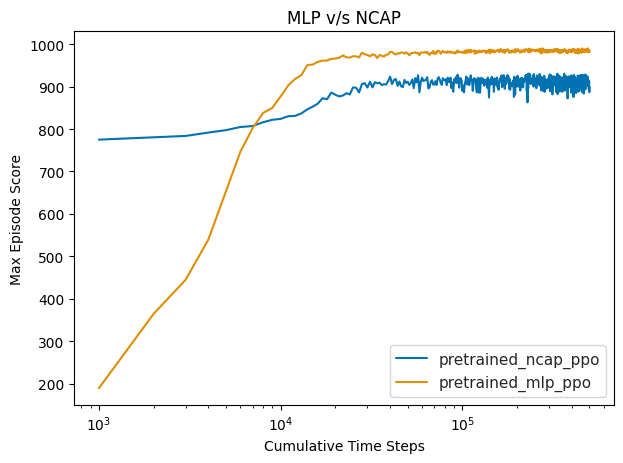

In [36]:
fig, ax = plt.subplots()

#Replace the paths with the path to models you trained to plot their performance.
paths = [
    'data/local/experiments/tonic/swimmer-swim/pretrained_ncap_ppo',
    'data/local/experiments/tonic/swimmer-swim/pretrained_mlp_ppo'
]
plot_performance(paths, ax=ax, title='MLP v/s NCAP')
plt.tight_layout()
plt.show()

❓



* ***Compare the performance and learning curve of NCAP to MLP for the basic swimmer agent.***
* ***Try testing the model on a modification of the environment (e.g., the 12-link swimmer) it was trained on.***
* ***What happens if we remove certain weight constraints (e.g., sign constraint) from the NCAP model?***

---
## Section 4: Visualizing the sparse network


Given the importance of architectural choices in our project we have provided a function which can visualize the network architecture. This includes the ability to render the NCAP network, representing the C. Elegans connectome.

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def draw_network(mode='NCAP', N=2, include_speed_control=False, include_turn_control=False):

    """
    Draws a network graph for a swimmer model based on either NCAP or MLP architecture.

    Parameters:
    - mode (str): Determines the architecture type ('NCAP' or 'MLP'). Defaults to 'NCAP'.
    - N (int): Number of joints in the swimmer model. Defaults to 2.
    - include_speed_control (bool): If True, includes nodes for speed control in the graph.
    - include_turn_control (bool): If True, includes nodes for turn control in the graph.
    """


    G = nx.DiGraph()

    n=2+N*4

    nodes =dict()

    if include_speed_control:
      nodes['1-s'] = n+7
    if include_turn_control:
      nodes['r'] = n+5
      nodes['l'] = n+3

    nodes['o'] = n-1
    nodes['$o^d$'] = n-0
    nodes['$o^v$']= n-2

    custom_node_positions = {}
    custom_node_positions['o'] = (1, nodes['o'])
    custom_node_positions['$o^d$'] = (1.5, nodes['$o^d$'])
    custom_node_positions['$o^v$'] = (1.5, nodes['$o^v$'])


    if include_speed_control:
      custom_node_positions['1-s'] = (1.5, nodes['1-s'])
    if include_turn_control:
      custom_node_positions['r'] = (1.5, nodes['r'])
      custom_node_positions['l'] = (1.5, nodes['l'])

    for i in range(1,N+1):
      nodes[f'$q_{i}$'] = 4*(N-i) + 1
      nodes[f'$q^d_{i}$'] = 4*(N-i) + 2
      nodes[f'$q^v_{i}$'] = 4*(N-i)
      nodes[f'$b^d_{i}$'] = 4*(N-i) + 2
      nodes[f'$b^v_{i}$'] = 4*(N-i)
      nodes[f'$m^d_{i}$'] = 4*(N-i) + 2
      nodes[f'$m^v_{i}$'] = 4*(N-i)
      nodes['$\overset{..}{q}$' + f'$_{i}$'] = 4*(N-i) + 1

      custom_node_positions[f'$q_{i}$'] = (1, nodes[f'$q_{i}$'])
      custom_node_positions[f'$q^d_{i}$'] = (1.5, nodes[f'$q^d_{i}$'])
      custom_node_positions[f'$q^v_{i}$'] = (1.5, nodes[f'$q^v_{i}$'])
      custom_node_positions[f'$b^d_{i}$'] = (2, nodes[f'$b^d_{i}$'])
      custom_node_positions[f'$b^v_{i}$'] = (2, nodes[f'$b^v_{i}$'])
      custom_node_positions[f'$m^d_{i}$'] = (2.5, nodes[f'$m^d_{i}$'])
      custom_node_positions[f'$m^v_{i}$'] = (2.5, nodes[f'$m^v_{i}$'])
      custom_node_positions['$\overset{..}{q}$' + f'$_{i}$'] = (3, nodes['$\overset{..}{q}$' + f'$_{i}$'])

    for node, layer in nodes.items():
        G.add_node(node, layer=layer)

    if mode=='NCAP':
        # Add edges between nodes
        edges_colors = ['green', 'orange', 'green', 'green']
        edge_labels = {
            ('o', '$o^d$'):'+1',
            ('o', '$o^v$'):'-1',
            ('$o^d$', '$b^d_1$'):'o',
            ('$o^v$', '$b^v_1$'):'o'
            }

        if include_speed_control:
          edges_colors += ['orange']
          edge_labels[('1-s', '$b^d_1$')] = 's, to all b'
        if include_turn_control:
          edges_colors += ['green', 'green']
          edge_labels[('r', '$b^d_1$')] = 't'
          edge_labels[('l', '$b^v_1$')] = 't'


        for i in range(1,N+1):
          if i < N:
            edges_colors += ['green', 'orange', 'green', 'green']

            edge_labels[((f'$q_{i}$', f'$q^d_{i}$'))] = '+1'
            edge_labels[((f'$q_{i}$', f'$q^v_{i}$'))] = '-1'
            edge_labels[((f'$q^d_{i}$', f'$b^d_{i+1}$'))] = 'p'
            edge_labels[((f'$q^v_{i}$', f'$b^v_{i+1}$'))] = 'p'

          edges_colors += ['green', 'orange', 'green', 'orange',
                          'orange', 'green']

          edge_labels[((f'$b^d_{i}$', f'$m^d_{i}$'))] = 'i'
          edge_labels[((f'$b^d_{i}$', f'$m^v_{i}$'))] = 'c'
          edge_labels[((f'$b^v_{i}$', f'$m^v_{i}$'))] = 'i'
          edge_labels[((f'$b^v_{i}$', f'$m^d_{i}$'))] = 'c'
          edge_labels[((f'$m^v_{i}$', '$\overset{..}{q}$' + f'$_{i}$'))] = '-1'
          edge_labels[((f'$m^d_{i}$', '$\overset{..}{q}$' + f'$_{i}$'))] = '+1'

        edges = edge_labels.keys()

    elif mode=='MLP':
      edges = []
      layers = [1, 1.5, 2, 2.5, 3]
      layers_nodes = [[], [], [], [], []]
      for key, value in custom_node_positions.items():
        ind = layers.index(value[0])
        layers_nodes[ind].append(key)
      for layer_ind in range(len(layers_nodes) - 1):
        for node1 in layers_nodes[layer_ind]:
          for node2 in layers_nodes[layer_ind+1]:
            edges.append((node1, node2))
      edges_colors = np.repeat('gray', len(edges))


    G.add_edges_from(edges)

    # Draw the graph using the custom node positions
    options = {"edge_color": edges_colors, "edgecolors": "tab:gray", "node_size": 500, 'node_color':'white'}
    nx.draw(G, pos=custom_node_positions, with_labels=True, arrowstyle="-", arrowsize=20, **options)
    if mode=='NCAP':
      nx.draw_networkx_edge_labels(G, pos=custom_node_positions, edge_labels=edge_labels)

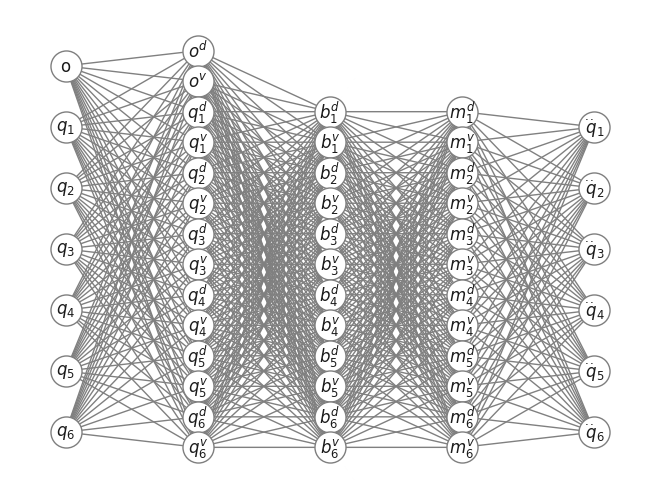

In [38]:
draw_network('MLP', N=6)

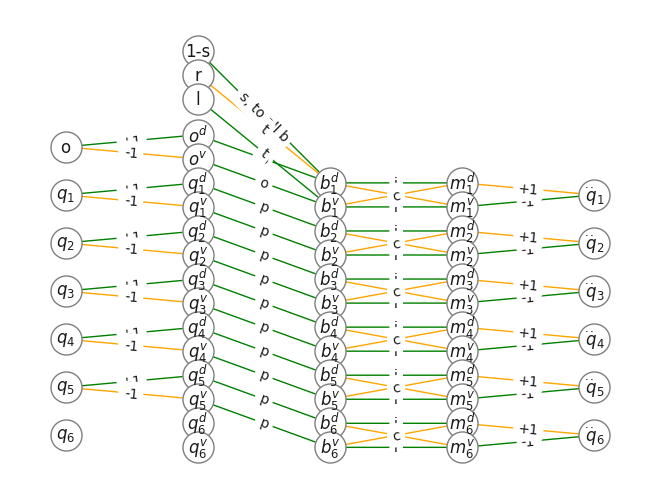

In [39]:
draw_network('NCAP', N=6, include_speed_control=True, include_turn_control=True)

Notice that the NCAP architecture is highly sparse and interpretable as compared to the MLP. Moreover notice that the ncap architecture can be completely embedded within a fully connected MLP of 3 hidden layers and ReLU nonlinearities. This enables us to do a thorough investigation into how specific architectural elements influence both performance and the learning process. By leveraging this capability, we can systematically analyze the impact of the architectural preferences inherent to the model and make better design choices.

*It might be useful to also visualize the network's activity for NCAP. Given it only has 4 learnable parameters it becomes much easier to interpret the network.*

---
## Conclusion



Based on the concepts we've discussed in this tutorial, you should now be equipped to advance with the project. Within this project, there are multiple pathways you can explore. For each pathway, you will delve deeply into one of the main sections outlined in this notebook, allowing for a thorough investigation of different factors that can influence performance:

*   ***Exploring the effects of environment:*** Investigate how different environmental settings impact agent performance. This could involve altering parameters of the environment or the types of tasks and reward functions. Understanding these effects can help in making better architectural choices and learning algorithms that result in agents that are robust and adaptable


*   ***Exploring the effects of learning algorithms:*** Standard RL algorithms often struggle with sparse and constrained networks, which can lead to suboptimal performance. Explore where these algorithms fail and analyze potential reasons for their limitations. Experiment with modifications or alternative algorithms that might overcome these challenges.


* ***Exploring the effects of model architecture:*** Investigate how various architectural decisions within the NCAP model influence its performance. Visualize the model and its activity and explore potential improvements by tweaking architectural elements, assessing how these changes affect learning outcomes and operational efficiency.